<a href="https://colab.research.google.com/github/unerriar/igm-selffocus-nn/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [ ]:
import os, os.path

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

import torch.cuda
import torch.nn as nn
from itertools import chain
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import Dataset, DataLoader

from google.colab import drive
from google.colab import output

In [ ]:
drive.mount('/content/drive')

In [ ]:
!unzip 'drive/MyDrive/Science/Neural networks/Datasets/NoisyDataset.zip'

#Helper classes

In [243]:
class FieldMediumDataset(Dataset):
    def __init__(self, dir, field_res, elems):
        super(FieldMediumDataset, self).__init__()

        self.field_res = field_res
        self.elements = elems
        self.dir = dir
        
        self.in_fields  = np.stack([self._extract_field('in_'+str(i)+'.bin') for i in range(*elems)])
        self.out_fields = np.stack([self._extract_field('out_'+str(i)+'.bin') for i in range(*elems)])
        self.medium = np.stack([self._extract_medium('medium_'+str(i)+'.bin') for i in range(*elems)])   

    def _extract_field(self, f):
        file_ = open(self.dir+'/'+f, 'rb')
        data  = np.fromfile(file_, dtype=np.complex64)
        file_.close()
        data_p = data[::2].reshape((self.field_res, self.field_res))
        data_m = data[1::2].reshape((self.field_res, self.field_res))
        return np.stack((np.real(data_p), np.imag(data_p), np.real(data_m), np.imag(data_m)))

    def _extract_medium(self, f):
        file_ = open(self.dir+'/'+f, 'rb')
        data  = np.fromfile(file_, dtype=np.float64).astype('float32')
        return data

    def __getitem__(self, i):
        return (self.in_fields[i], self.out_fields[i], self.medium[i])

    def __len__(self):
        return self.elements[1] - self.elements[0]

class Workflow():
    def __init__(self, model, model_name='Untitled', save_dir=None,
                 loss_fn=nn.MSELoss, optimizer=torch.optim.SGD, optim_params={'lr':.1}):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print('using ' + self.device)
        
        self.model = model.to(self.device)
        self.loss_fn = loss_fn()
        self.save_dir = save_dir
        self.optimizer = optimizer(model.parameters(), **optim_params)
        self.model_name = model_name
        self.optim_params = optim_params
        
        self.best_loss = 9999 #pseudoinfinity
    
    def train(self, n_epoch, trainloader, testloader,
              history_tracing=50, refresh_time=5, in_fields=True):
        """
        Full train-test routine
        
        Parameters

        n_epochs : int
            number of epochs to learn
        trainloader : torch.utils.data.DataLoader
            train dataset dataloader
        testloader : torch.utils.data.DataLoader
            test dataset dataloader
        history_tracing : int
            number of past epochs to track detailed data about.
            Does not affect model behaviour
        refresh_time : int
            number of epochs between plots and info being refreshed.
            Does not affect the model behaviour
        """
        lr = self.optim_params['lr']

        train_loss_history = np.empty(0)
        test_loss_history  = np.empty(0)
        
        for e in range(n_epoch):
            train_loss = self._train(trainloader, in_fields=in_fields)
            test_loss  = self._test(testloader, in_fields=in_fields)

            train_loss_history = np.append(train_loss_history, train_loss)
            test_loss_history  = np.append(test_loss_history,  test_loss)
            
            #loss dynamics monitoring
            hist_len = min(e+1, history_tracing)
            test_loss_mean  = np.mean(test_loss_history[-hist_len:])
            test_loss_std   = np.std(test_loss_history[-hist_len:])
            test_loss_delta = test_loss - test_loss_history[-hist_len]

            #saving best model
            if test_loss < self.best_loss:
                self.best_loss = test_loss
                torch.save(model.state_dict(), self.save_dir+'/'+self.model_name+'.pth')

            #learning visualization
            if (e+1) % refresh_time == 0:
                output.clear()
                print(f'Epoch {e+1}/{n_epoch}:\nTrain loss: {train_loss:.4}, test loss: {test_loss:.4}')
                print(f'Test loss during last {hist_len} epochs:')
                print(f'Mean: {test_loss_mean:.4}, std dev: {test_loss_std:.4}, delta: {test_loss_delta:.6}:')
                print(f'Best test loss: {self.best_loss:.4}')

                fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,7))
                ax1.plot(range(len(train_loss_history)), train_loss_history, label='train')
                ax1.plot(range(len(test_loss_history )), test_loss_history,  label='test')
                ax1.set_xlabel('epoch')
                ax1.set_ylabel('loss')
                ax1.legend()
                
                ax2.plot(range(len(train_loss_history)), train_loss_history, label='train')
                ax2.plot(range(len(test_loss_history )), test_loss_history,  label='test')
                ax2.set_yscale('log')
                ax2.set_xlabel('epoch')
                ax2.set_ylabel('loss (log scale)')
                ax2.legend()

                plt.show()

    def load_best(self):
        """
        Upload best saved model.
        """
        model.load_state_dict(torch.load(self.save_dir+'/'+self.model_name+'.pth'))

    def _train(self, dataloader, in_fields=True):
        """
        Single epoch train phase
        """
        batch_num = len(dataloader)
        
        self.model.train()

        ep_loss = 0
        for batch, (in_field, out_field, medium) in enumerate(dataloader):
            in_field, out_field, medium = in_field.to(self.device), out_field.to(self.device), medium.to(self.device)

            #error computation
            if in_fields:
                predict = model(torch.cat((in_field, out_field), axis=1))
            else:
                predict = model(torch.cat((0*in_field, out_field), axis=1))
            loss = self.loss_fn(predict, medium)
            ep_loss += loss.item()

            #backpropagation
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        return ep_loss / batch_num

    def _test(self, dataloader, in_fields=True):
        """
        Single epoch test phase
        """
        batch_num = len(dataloader)
        
        self.model.eval()

        ep_loss = 0
        for batch, (in_field, out_field, medium) in enumerate(dataloader):
            in_field, out_field, medium = in_field.to(self.device), out_field.to(self.device), medium.to(self.device)

            #error computation
            if in_fields:
                predict = model(torch.cat((in_field, out_field), axis=1))
            else:
                predict = model(torch.cat((0*in_field, out_field), axis=1))
            loss = self.loss_fn(predict, medium)
            ep_loss += loss.item()
    
        return ep_loss / batch_num


#Network

In [ ]:
class Network(nn.Module):
    def __init__(self, neuron_n=(16, 32, 16, 128, 64), cact=nn.Tanh, lact=nn.ReLU):
        super(Network, self).__init__()
                
        self.convolutions = nn.Sequential(
            nn.Conv2d(8, neuron_n[0], 4, 4), #64
            cact(),
            nn.Conv2d(neuron_n[0], neuron_n[1], 4, 4), #16
            cact(),
            nn.Conv2d(neuron_n[1], neuron_n[2], 4, 4), #4
            cact(),
        )
        self.flatten = nn.Flatten()
        self.linear  = nn.Sequential(
            nn.Linear(neuron_n[2] * 4**2, neuron_n[3]),
            lact(),
            nn.Linear(neuron_n[3], neuron_n[4]),
            lact(),
            nn.Linear(neuron_n[4], 4)
        )

    def forward(self, x):
        x = self.convolutions(x)
        x = self.flatten(x)
        return self.linear(x)

#Dataset construction

In [244]:
field_resolution = 256
batch_size = 64
total_n = 1024
test_n  = 256
valid_n = 128
train_n = total_n - test_n - valid_n
dir = 'NoisyDataset'

valid_dataset = FieldMediumDataset(dir, field_resolution,  [0, valid_n])
test_dataset  = FieldMediumDataset(dir, field_resolution,  [valid_n, valid_n+test_n])
train_dataset = FieldMediumDataset(dir, field_resolution,  [valid_n+test_n, total_n])

valid_dataloader = DataLoader(valid_dataset, batch_size, shuffle=True)
test_dataloader  = DataLoader(test_dataset,  batch_size, shuffle=True)
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)

#Training

In [257]:
torch.manual_seed(0)

model = Network((16, 32, 32, 128, 64))
optim_params = {'lr':.0002}

workflow = Workflow(
    model, 'Light_model',
    save_dir = '/content/drive/MyDrive/Science/Neural networks/Saved models',
    optimizer = torch.optim.Adam,
    optim_params = optim_params
)

using cuda


Epoch 1000/1000:
Train loss: 0.04772, test loss: 0.105
Test loss during last 20 epochs:
Mean: 0.1045, std dev: 0.003543, delta: -0.00432416:
Best test loss: 0.09297


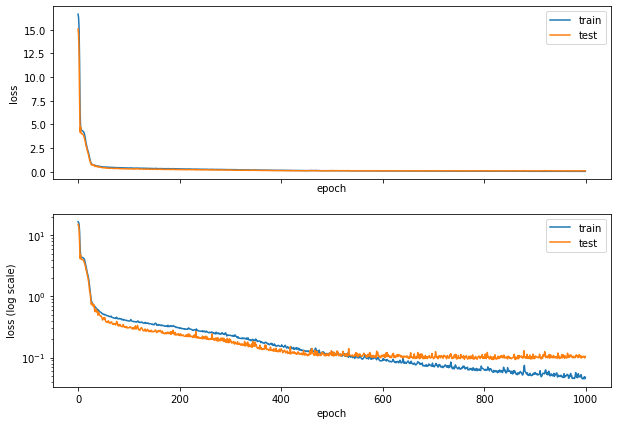

In [258]:
workflow.train(
    1000, train_dataloader, test_dataloader,
    history_tracing = 20,
    refresh_time = 20
)

**Noisy model**
*1000 epochs (~16min):*

(16, 32, 16, 128, 32) 0.0854

(16, 32, 16, 128, 64) 0.0745

(8, 16, 16, 128, 64) 0.1089

(32, 64, 64, 128, 64) 0.0732

(16, 32, 16, 128, 64), cact=nn.ReLU 0.0899

(16, 32, 16, 256, 64) 0.0930


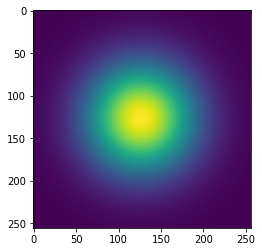

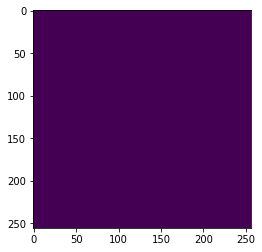

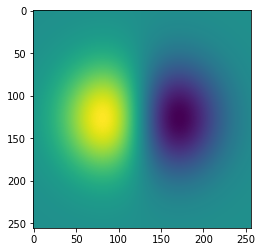

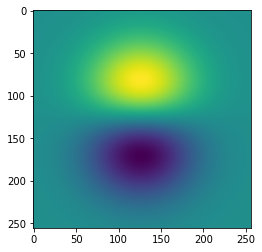

In [ ]:
in_field, out_field, medium = next(iter(test_dataloader))

field=in_field[10].detach().numpy()
plt.imshow(field[0])
plt.show()
plt.imshow(field[1])
plt.show()
plt.imshow(field[2])
plt.show()
plt.imshow(field[3])
plt.show()

#Explaining

In [ ]:
for i, layer in enumerate(model.parameters()):
    print(layer.shape)

torch.Size([16, 8, 4, 4])
torch.Size([16])
torch.Size([32, 16, 4, 4])
torch.Size([32])
torch.Size([64, 32, 4, 4])
torch.Size([64])
torch.Size([32, 64, 4, 4])
torch.Size([32])
torch.Size([16, 32, 4, 4])
torch.Size([16])
torch.Size([128, 256])
torch.Size([128])
torch.Size([128, 128])
torch.Size([128])
torch.Size([4, 128])
torch.Size([4])


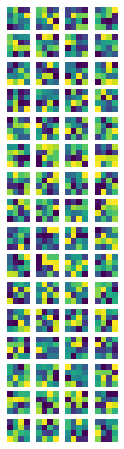

In [ ]:
weights = model.convolutions[0].weight.cpu().detach().numpy()
shape = weights.shape
min_weight, max_weight = weights.min(), weights.max()
weights = (weights - min_weight)/(max_weight - min_weight)

fig, axes = plt.subplots(shape[0], shape[1], figsize=(shape[1]/2, shape[0]/2))
for i in range(shape[0]):
    for j in range(shape[1]):
        axes[i][j].set_axis_off()
        axes[i][j].imshow(
            weights[i][j],
        )

In [ ]:
field, medium = next(iter(test_dataloader))
predict = model(field.float().to('cuda'))

i=3
print(medium[i])
print(predict[i])

tensor([1.5797, 0.6722, 0.9962, 8.4765], dtype=torch.float64)
tensor([1.5828, 0.5013, 0.8104, 8.5327], device='cuda:0',
       grad_fn=<SelectBackward0>)
